In [27]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0,VGG16
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
csv_file_path = "E:\/통합_신체정보데이터.csv"
df = pd.read_csv (csv_file_path,encoding='utf8')
df

,model_num,height,weight,body_fat,waist,belly_waist,hip,thigh,bust,arm,shoulder,insim,gender,age,body_shape
0,F004,164.1,49.4,21.8,64.1,67.2,87.8,50.3,80.5,24.8,33.5,75.4,F,30,모래시계형 (Hourglass)
1,F005,152.9,51.9,24.2,66.2,79.2,90.5,55.0,80.5,29.2,33.1,63.3,F,44,배형 (Belly)
2,F006,159.7,47.6,20.0,64.4,74.5,87.3,47.6,79.5,25.1,32.1,66.5,F,50,배형 (Belly)
3,F007,162.2,59.1,27.8,74.8,82.3,92.1,52.2,93.0,26.7,33.6,70.6,F,42,배형 (Belly)
4,F008,157.6,61.6,36.4,82.6,89.0,92.2,51.5,99.7,29.0,36.6,66.6,F,65,사과형 (Apple)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,M499,169.9,65.2,17.8,81.8,82.0,87.0,48.4,92.7,29.3,39.1,69.1,M,53,사과형 (Apple)
988,M500,173.7,67.2,20.3,72.3,77.0,93.9,55.3,91.7,31.9,39.0,74.8,M,30,모래시계형 (Hourglass)
989,F013,152.0,74.0,50.5,99.7,104.8,105.4,64.4,101.9,32.8,33.8,65.0,F,50,사과형 (Apple)
990,F014,160.2,51.2,25.0,68.5,77.0,89.0,52.2,81.0,25.8,35.8,68.4,F,57,배형 (Belly)


In [3]:
df.isnull().sum()

model_num      0
height         0
weight         0
body_fat       0
waist          0
belly_waist    0
hip            0
thigh          0
bust           0
arm            0
shoulder       0
insim          0
gender         0
age            0
body_shape     0
dtype: int64

In [4]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0, VGG16
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.preprocessing import image

# 이미지 데이터 경로
image_dir = "E:/image_data/"

# EfficientNetB0 & VGG16 모델 로드
eff_model = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg")
vgg_model = VGG16(weights="imagenet", include_top=False, pooling="avg")

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(img_path, preprocess_func):
    """이미지를 로드하고 CNN 모델에 맞게 전처리"""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_func(img_array)  # 모델별 전처리 함수 적용
    return img_array

# EfficientNetB0 & VGG16 특징 벡터 추출 함수
def extract_features_for_model(model_num):
    """각 model_num에 해당하는 16개 이미지에서 EfficientNetB0 & VGG16 특징 벡터 추출"""
    eff_features_list = []
    vgg_features_list = []

    for i in range(1, 17):  # 1~16 이미지 로드
        img_filename = f"resize_{model_num}_{i}.jpg"
        img_path = os.path.join(image_dir, img_filename)

        if os.path.exists(img_path):
            # EfficientNetB0 특징 벡터 추출
            img_array_eff = load_and_preprocess_image(img_path, eff_preprocess)
            eff_features = eff_model.predict(img_array_eff).flatten()
            eff_features_list.append(eff_features)

            # VGG16 특징 벡터 추출
            img_array_vgg = load_and_preprocess_image(img_path, vgg_preprocess)
            vgg_features = vgg_model.predict(img_array_vgg).flatten()
            vgg_features_list.append(vgg_features)
        else:
            print(f"이미지 없음: {img_path}")
            return None, None  # 한 개라도 없으면 무효 처리

    # 16개 이미지의 평균 벡터 계산
    if eff_features_list and vgg_features_list:
        return np.mean(eff_features_list, axis=0), np.mean(vgg_features_list, axis=0)  # 평균값 사용
    return None, None

# CSV 데이터 불러오기 (신체 측정값)
df = pd.read_csv("E://통합_신체정보데이터.csv")

# CNN 특징 벡터 추가
feature_data = []
missing_models = []  # 누락된 모델 저장 리스트

for index, row in df.iterrows():
    model_num = row["model_num"]  # 모델 ID 가져오기
    eff_features, vgg_features = extract_features_for_model(model_num)

    if eff_features is not None and vgg_features is not None:
        combined_data = np.concatenate([
            [model_num],  # model_num 포함
            eff_features,  # EfficientNetB0 특징 벡터 (1280차원)
            vgg_features,  # VGG16 특징 벡터 (512차원)
            row[["height", "weight", "belly_waist", "waist", "hip", "thigh", "bust", "shoulder"]].values  # 신체 측정값
        ])
        feature_data.append(combined_data)
    else:
        missing_models.append(model_num)  # 이미지 누락된 model_num 저장

# 데이터프레임 변환
columns = ["model_num"] + \
          [f"eff_feature_{i}" for i in range(len(eff_features))] + \
          [f"vgg_feature_{i}" for i in range(len(vgg_features))] + \
          ["height", "weight", "belly_waist", "waist", "hip", "thigh", "bust", "shoulder"]

final_df = pd.DataFrame(feature_data, columns=columns)

# 결과 확인
print("EfficientNetB0 + VGG16 특징 벡터 추출 완료")
print(final_df.head())  # 상위 5개 출력

# CSV 저장
final_df.to_csv("CNN_특징벡터_신체데이터.csv", index=False)

# 누락된 모델 출력
if missing_models:
    print(f"누락된 모델 {len(missing_models)}개:", missing_models)


이미지 없음: E:/image_data/resize_F004_1.jpg
이미지 없음: E:/image_data/resize_F005_1.jpg
이미지 없음: E:/image_data/resize_F006_1.jpg
이미지 없음: E:/image_data/resize_F007_1.jpg
이미지 없음: E:/image_data/resize_F008_1.jpg


KeyboardInterrupt: 

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# CSV 데이터 불러오기
file_path = "CNN_특징벡터_신체데이터.csv"
df = pd.read_csv(file_path)
df = df.drop(columns=["model_num"], errors="ignore")  # "model_num"이 있으면 제거
# 특징 벡터 (X)와 타겟 데이터 (Y) 분리
X = df.iloc[:, :-8].values  # EfficientNetB0 + VGG16 특징 벡터
y = df[["height", "weight", "belly_waist", "waist", "hip", "thigh", "bust", "shoulder"]].values  # 신체 측정값

# 훈련/검증 데이터 분리 (80% 훈련, 20% 검증)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("훈련 데이터 크기:", X_train.shape, "검증 데이터 크기:", X_test.shape)


훈련 데이터 크기: (785, 1792) 검증 데이터 크기: (197, 1792)


In [33]:
# 훈련 & 검증 데이터 학습 과정 출력
# XGBoost용 DMatrix 변환 (XGB.train()을 사용하려면 필요)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost 모델 파라미터 설정
params = {
    "objective": "reg:squarederror",
    "eval_metric": ["mae", "rmse"],  # MAE와 RMSE를 모두 평가 지표로 사용
    "learning_rate": 0.05,
    "max_depth": 6,
    "num_boost_round": 200,
    "random_state": 42
}

# 학습 과정 저장할 딕셔너리 생성
evals_result = {}

# 학습 실행 (early stopping 포함)
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,  # 트리 개수
    evals=[(dtrain, "train"), (dtest, "test")],  # 학습 및 검증 데이터 설정
    early_stopping_rounds=10,  # 10회 이상 성능 개선 없으면 조기 종료
    evals_result=evals_result,  # 학습 과정 저장
    verbose_eval=True  # 학습 로그 출력
)


C:\Users\4545\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [15:07:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mae:25.02227	train-rmse:34.68060	test-mae:25.14801	test-rmse:34.79186
[1]	train-mae:23.80722	train-rmse:32.97847	test-mae:23.99521	test-rmse:33.11842
[2]	train-mae:22.65393	train-rmse:31.36210	test-mae:22.89631	test-rmse:31.52812
[3]	train-mae:21.55809	train-rmse:29.82625	test-mae:21.85899	test-rmse:30.02091
[4]	train-mae:20.51516	train-rmse:28.36701	test-mae:20.87025	test-rmse:28.58942
[5]	train-mae:19.52793	train-rmse:26.98060	test-mae:19.93368	test-rmse:27.23152
[6]	train-mae:18.58738	train-rmse:25.66341	test-mae:19.04821	test-rmse:25.94350
[7]	train-mae:17.69204	train-rmse:24.41161	test-mae:18.20281	test-rmse:24.72310
[8]	train-mae:16.84182	train-rmse:23.22246	test-mae:17.40455	test-rmse:23.56833
[9]	train-mae:16.03418	train-rmse:22.09280	test-mae:16.65275	test-rmse:22.47860
[10]	train-mae:15.26543	train-rmse:21.01958	test-mae:15.93535	test-rmse:21.43984
[11]	train-mae:14.53489	train-rmse:19.99960	test-mae:15.25699	test-rmse:20.45928
[12]	train-mae:13.84073	train-rmse:19.

[106]	train-mae:0.40615	train-rmse:0.75355	test-mae:3.49740	test-rmse:5.37143
[107]	train-mae:0.39809	train-rmse:0.74569	test-mae:3.49609	test-rmse:5.37007
[108]	train-mae:0.39034	train-rmse:0.73839	test-mae:3.49475	test-rmse:5.36894
[109]	train-mae:0.38241	train-rmse:0.73060	test-mae:3.49301	test-rmse:5.36781
[110]	train-mae:0.37601	train-rmse:0.72443	test-mae:3.49196	test-rmse:5.36709
[111]	train-mae:0.36852	train-rmse:0.71749	test-mae:3.49031	test-rmse:5.36569
[112]	train-mae:0.36200	train-rmse:0.71149	test-mae:3.48795	test-rmse:5.36369
[113]	train-mae:0.35534	train-rmse:0.70568	test-mae:3.48651	test-rmse:5.36250
[114]	train-mae:0.34879	train-rmse:0.69993	test-mae:3.48546	test-rmse:5.36172
[115]	train-mae:0.34239	train-rmse:0.69421	test-mae:3.48401	test-rmse:5.36077
[116]	train-mae:0.33639	train-rmse:0.68913	test-mae:3.48268	test-rmse:5.35962
[117]	train-mae:0.33061	train-rmse:0.68413	test-mae:3.48136	test-rmse:5.35829
[118]	train-mae:0.32427	train-rmse:0.67870	test-mae:3.47972	test

In [36]:
# 예측 수행
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

In [39]:
mae = mean_absolute_error(y_test,y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'mae:{mae:.2f},rmse:{rmse:.2f},r2:{r2:.2f}')

mae:3.45,rmse:5.33,r2:0.54


In [41]:
import numpy as np
num_samples = 5
print("실제값 vs 예측값 비교:")
for i in range(num_samples):
    print(f"실제: {y_test[i]}, 예측: {np.round(y_pred[i], 2)}")

실제값 vs 예측값 비교:
실제: [171.6  98.5 103.   99.7 110.   66.2 112.4  39.7], 예측: [173.06  78.97  94.41  93.1   97.18  58.29  96.43  40.4 ]
실제: [173.5  79.6  92.4  92.2  97.2  59.2  98.9  36.4], 예측: [173.74  77.53  93.58  90.51  96.71  54.91  96.3   39.62]
실제: [168.4  66.1  86.4  88.3  89.2  49.2  90.8  38.2], 예측: [167.71  68.21  85.38  84.48  93.33  53.44  91.54  38.42]
실제: [174.6  68.7  84.4  79.7  95.8  58.1  84.1  39.4], 예측: [170.76  68.36  85.1   80.03  95.57  55.96  93.77  39.02]
실제: [162.1  90.9 103.6 104.3 111.   66.3 114.8  37.3], 예측: [160.63  64.93  93.34  89.65  98.84  59.45  96.14  35.96]


In [42]:
import pickle
with open("xgboost_model.pkl", "wb") as file:
    pickle.dump(model, file)

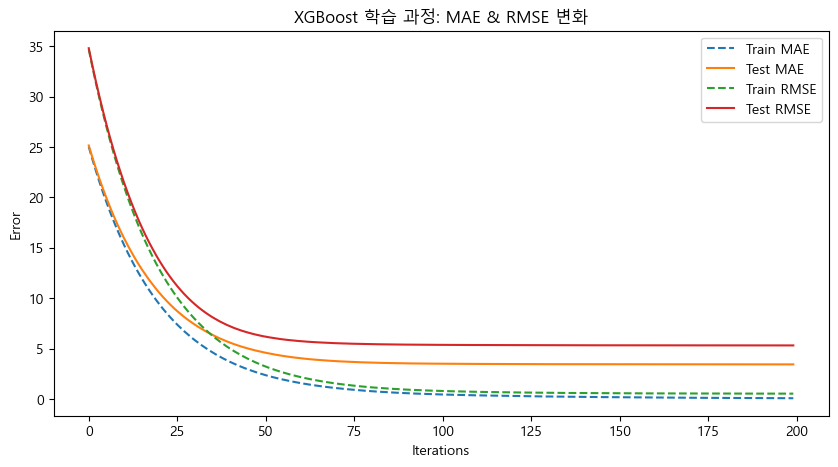

In [45]:
plt.rc('font', family='Malgun Gothic')
# MAE & RMSE 그래프 시각화
plt.figure(figsize=(10, 5))

# MAE 그래프
plt.plot(evals_result['train']['mae'], label="Train MAE", linestyle='--')
plt.plot(evals_result['test']['mae'], label="Test MAE")

# RMSE 그래프
plt.plot(evals_result['train']['rmse'], label="Train RMSE", linestyle='--')
plt.plot(evals_result['test']['rmse'], label="Test RMSE")

plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title("XGBoost 학습 과정: MAE & RMSE 변화")
plt.legend()
plt.show()


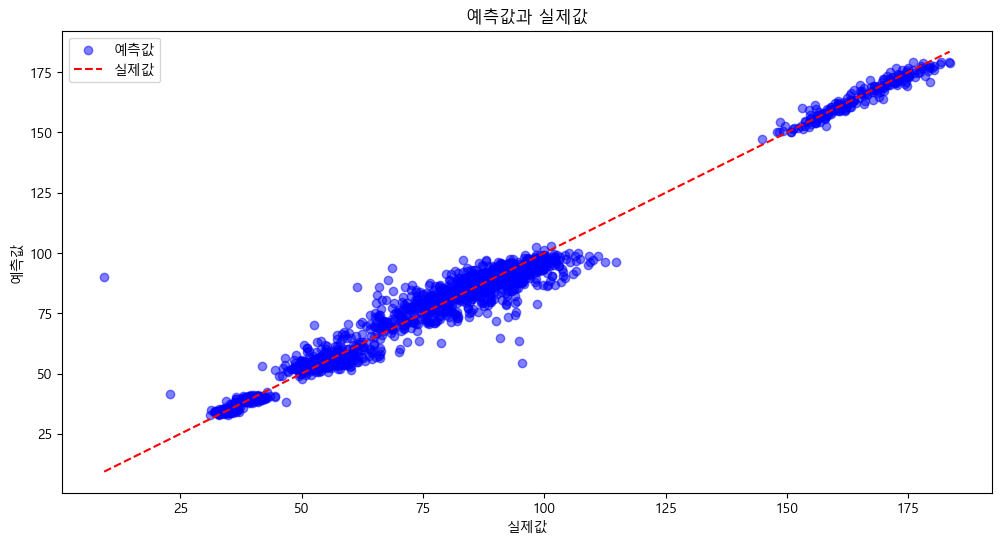

In [55]:
# y_test와 y_pred가 numpy 배열인지 확인 후 변환
y_test = np.array(y_test).flatten()
y_pred = np.array(y_pred).flatten()

plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue",label="예측값")  # 예측값 vs 실제값
plt.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], color="red", linestyle="--",label="실제값")  # 완벽한 예측선
plt.xlabel("실제값")
plt.ylabel("예측값")
plt.title("예측값과 실제값")
plt.legend()
plt.show()


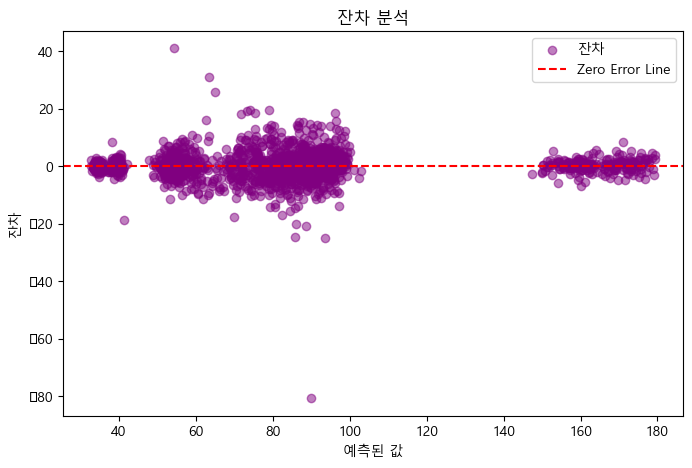

In [58]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5, color="purple", label="잔차")
plt.axhline(y=0, color="red", linestyle="--", label="Zero Error Line")
plt.xlabel("예측된 값")
plt.ylabel("잔차")
plt.title("잔차 분석")
plt.legend()
plt.show()

C:\Users\4545\AppData\Local\Temp\ipykernel_3176\2018050263.py:38: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  plt.tight_layout()
C:\Users\4545\AppData\Local\Temp\ipykernel_3176\2018050263.py:38: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  plt.tight_layout()
C:\Users\4545\AppData\Local\Temp\ipykernel_3176\2018050263.py:38: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from current font.
  plt.tight_layout()
C:\Users\4545\AppData\Local\Temp\ipykernel_3176\2018050263.py:38: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  plt.tight_layout()
C:\Users\4545\AppData\Local\Temp\ipykernel_3176\2018050263.py:38: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  plt.tight_layout()
C:\Users\4545\AppData\Local\Temp\ipykernel_3176\2018050263.py:38: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  plt.tight_layout()
C:\Users\

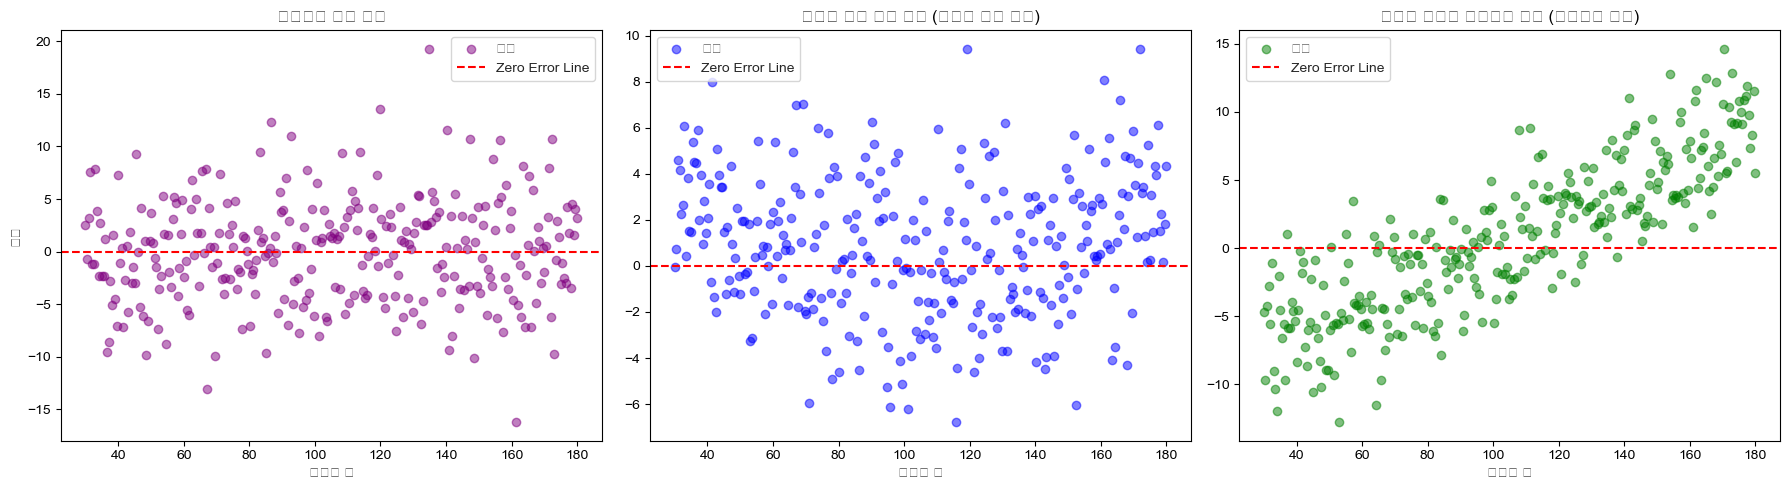

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 랜덤 데이터 생성 (예측값과 실제값의 차이인 잔차)
np.random.seed(42)
predicted_values = np.linspace(30, 180, 300)
residuals_random = np.random.normal(loc=0, scale=5, size=300)  # 무작위로 분포하는 잔차
residuals_pattern = 0.0005 * (predicted_values - 100) ** 2 + np.random.normal(loc=0, scale=3, size=300)  # 패턴을 가지는 잔차
residuals_increasing = (predicted_values - 100) * 0.1 + np.random.normal(loc=0, scale=3, size=300)  # 분산이 증가하는 잔차

# 그래프 설정
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.set_style("whitegrid")

# 1. 이상적인 경우 (무작위 분포)
axes[0].scatter(predicted_values, residuals_random, color="purple", alpha=0.5, label="잔차")
axes[0].axhline(y=0, color="r", linestyle="--", label="Zero Error Line")
axes[0].set_title("이상적인 잔차 분포")
axes[0].set_xlabel("예측된 값")
axes[0].set_ylabel("잔차")
axes[0].legend()

# 2. 패턴이 있는 경우 (모델이 비선형 패턴을 학습하지 못한 경우)
axes[1].scatter(predicted_values, residuals_pattern, color="blue", alpha=0.5, label="잔차")
axes[1].axhline(y=0, color="r", linestyle="--", label="Zero Error Line")
axes[1].set_title("패턴이 있는 잔차 분포 (비선형 관계 존재)")
axes[1].set_xlabel("예측된 값")
axes[1].legend()

# 3. 분산이 증가하는 경우 (이분산성 문제)
axes[2].scatter(predicted_values, residuals_increasing, color="green", alpha=0.5, label="잔차")
axes[2].axhline(y=0, color="r", linestyle="--", label="Zero Error Line")
axes[2].set_title("잔차의 분산이 증가하는 경우 (이분산성 문제)")
axes[2].set_xlabel("예측된 값")
axes[2].legend()

plt.tight_layout()
plt.show()
